In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import dill
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:

if os.path.exists('final_project.db'):
    dill.load_session('final_project.db')

In [3]:
# convert 2019 objects to correct types
df_2019['datetime'] = pd.to_datetime(df_2019['datetime'], format='%Y-%m-%d')
df_2019['gender'] = df_2019['gender'].astype('category')
df_2019['age_group'] = df_2019['age_group'].astype('category')
df_2019['country'] = df_2019['country'].astype('category')
df_2019['major'] = df_2019['major'].astype('category')
df_2019.drop(columns=['Unnamed: 0'], inplace=True)

# convert 2020 objects to correct types
df_2020['datetime'] = pd.to_datetime(df_2020['datetime'], format='%Y-%m-%d')
df_2020['gender'] = df_2020['gender'].astype('category')
df_2020['age_group'] = df_2020['age_group'].astype('category')
df_2020['country'] = df_2020['country'].astype('category')
df_2020['major'] = df_2020['major'].astype('category')
df_2020.drop(columns=['Unnamed: 0'], inplace=True)

display(df_2019.head())
display(df_2020.head())

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019
1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016
2,2019-01-01,2,9.30,98.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2019-01-01,3,103.13,453.40,M,18 - 34,United Kingdom,LONDON 2017
4,2019-01-01,4,34.67,185.65,M,35 - 54,United States,BOSTON 2017


,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,70.33,394.200000,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,14.65,79.066667,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,41.41,195.666667,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,41.34,209.100000,M,35 - 54,United States,BOSTON 2017


In [4]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893424 entries, 0 to 1893423
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     category      
 5   age_group  category      
 6   country    category      
 7   major      category      
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 68.7 MB


In [5]:
# Add new columns where, 52:
# Rows are individual athletes
# Columns are the mileage for x week

df_2019.groupby(['athlete'])['datetime'].value_counts()


athlete  datetime  
0        2019-01-01    1
         2019-01-08    1
         2019-01-15    1
         2019-01-22    1
         2019-01-29    1
                      ..
37598    2019-11-26    1
         2019-12-03    1
         2019-12-10    1
         2019-12-17    1
         2019-12-24    1
Name: count, Length: 1893424, dtype: int64

In [6]:
df_2019_new = df_2019.pivot_table(
    index='athlete',
    columns='datetime',
    values='distance',
    aggfunc='sum',
    fill_value=0
)
df_2019_new.columns = [f'week_{i}_distance' for i in range(df_2019_new.shape[1])]
df_2019_new = df_2019_new.reset_index()
mask = ~df_2019['athlete'].duplicated()
df_2019_new['age_group'] = df_2019[mask]['age_group']
df_2019_new['country'] = df_2019[mask]['country']
df_2019_new['gender'] = df_2019[mask]['gender']
df_2019_new['major'] = df_2019[mask]['major']
age_map = {}
# compute mean age for each age group to convert to numeric
for age_group in df_2019_new['age_group'].unique():
    ages_split = age_group.split()
    mean_age = 0
    if ages_split[1] == '-':
        mean_age = (int(ages_split[0]) + int(ages_split[2])) / 2
    else:
        mean_age = (55 + 75) / 2
    age_map[age_group] = mean_age
df_2019_new['age_group'] = pd.Series(df_2019_new['age_group'].map(age_map), dtype=float)
df_2019_new = pd.get_dummies(df_2019_new, columns=['country'])
df_2019_new

,athlete,week_0_distance,week_1_distance,week_2_distance,week_3_distance,week_4_distance,week_5_distance,week_6_distance,week_7_distance,week_8_distance,...,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zimbabwe
0,0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,...,False,False,False,False,True,False,False,False,False,False
1,1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,...,False,False,False,False,False,False,False,False,False,False
2,2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,...,False,False,False,True,False,False,False,False,False,False
3,3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,...,False,False,False,True,False,False,False,False,False,False
4,4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,37594,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,...,False,False,False,True,False,False,False,False,False,False
36408,37595,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,...,False,False,False,False,True,False,False,False,False,False
36409,37596,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,...,False,False,False,False,True,False,False,False,False,False
36410,37597,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,...,False,False,False,False,True,False,False,False,False,False


In [7]:
df_2019_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36412 entries, 0 to 36411
Columns: 185 entries, athlete to country_Zimbabwe
dtypes: bool(129), category(2), float64(53), int64(1)
memory usage: 19.6 MB


In [13]:
country_columns = df_2019_new.columns[df_2019_new.columns.str.startswith('country_')]
X_2019 = df_2019_new.drop(columns=['gender','major','athlete'] + list(country_columns))
y_2019 = df_2019_new['gender']
X_2019_train, X_2019_test, y_2019_train, y_2019_test = train_test_split(X_2019, y_2019, test_size=0.3)

In [20]:
X_2019

,week_0_distance,week_1_distance,week_2_distance,week_3_distance,week_4_distance,week_5_distance,week_6_distance,week_7_distance,week_8_distance,week_9_distance,...,week_43_distance,week_44_distance,week_45_distance,week_46_distance,week_47_distance,week_48_distance,week_49_distance,week_50_distance,week_51_distance,age_group
0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,0.00,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.000,0.000000,26.0
1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,63.59,...,46.240,56.770,27.38,10.770,30.30,39.47,50.439,62.530,70.280000,44.5
2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,43.17,...,24.120,0.000,11.63,9.380,22.90,25.54,14.490,0.000,8.163750,44.5
3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,74.42,...,33.960,41.910,32.24,40.300,42.02,42.15,45.710,21.120,63.516250,26.0
4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,17.39,...,17.479,29.929,22.05,32.210,41.05,44.31,5.110,3.830,9.966250,44.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,107.05,...,180.009,175.120,56.29,34.870,48.25,38.37,40.410,48.029,12.835375,26.0
36408,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,123.68,...,97.540,126.909,123.85,129.499,135.63,136.03,135.970,116.689,151.725000,26.0
36409,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,43.37,...,77.600,100.120,0.00,29.710,68.91,48.00,49.910,8.060,35.770000,26.0
36410,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,53.58,...,20.000,45.930,39.58,53.160,15.53,37.90,24.670,31.530,31.937500,26.0


In [23]:
rf = RandomForestClassifier(max_depth=5)
rf_cv_score = cross_val_score(rf, X_2019_train, y_2019_train, cv=5)
print(f'Random Forest Classifier CV Score: {rf_cv_score.mean()}')
rf.fit(X_2019_train, y_2019_train)
print(f'Random Forest Classifier Train Score: {rf.score(X_2019_train, y_2019_train)}')
print(f'Random Forest Classifier Test Score: {rf.score(X_2019_test, y_2019_test)}')

Random Forest Classifier CV Score: 0.7555712469577063
Random Forest Classifier Train Score: 0.7556104833647207
Random Forest Classifier Test Score: 0.756590992310509


### Predicting Next Week's Distance based on previous X weeks

In [51]:
def predict_distance(week_x):
    target = 'week_' + str(week_x) + '_distance'
    features = [col for col in df_2019_new.columns if col.startswith('week_') and int(col.split('_')[1]) < week_x]
    X = df_2019_new[features]
    y = df_2019_new[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=5,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    # print(f'RMSE for week {week_x}: {rmse}')
    # print(f'Training accuracy for week {week_x}: {train_score}')
    # print(f'Testing accuracy for week {week_x}: {test_score}')
    return rmse, train_score, test_score

100%|██████████| 51/51 [17:36<00:00, 20.72s/it]


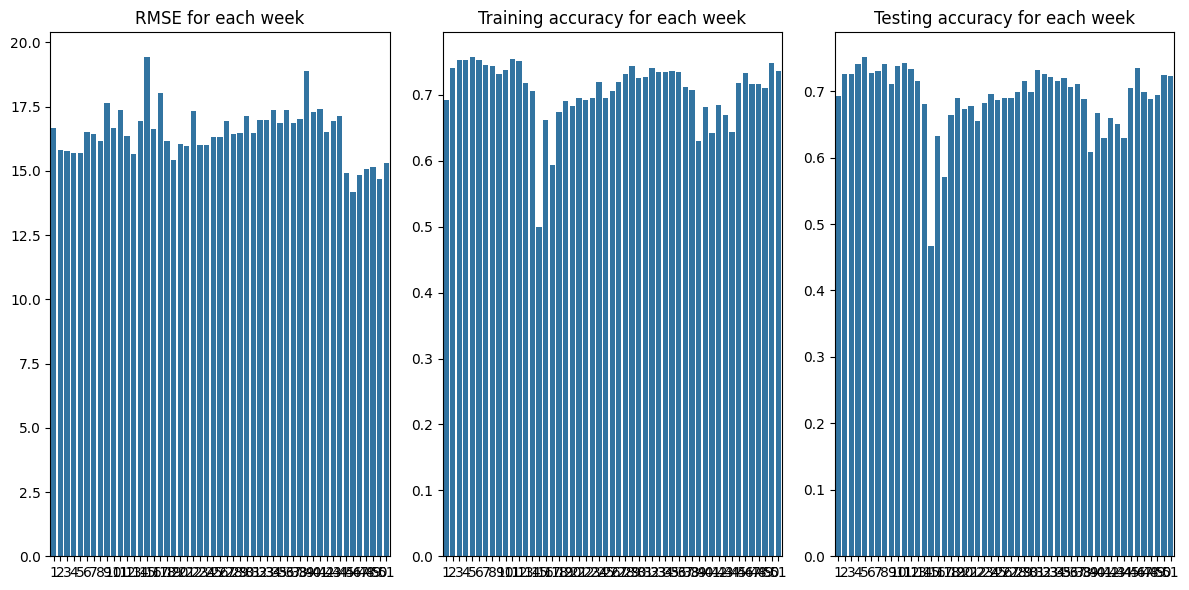

In [54]:
rmses = []
train_scores = []
test_scores = []
for week_x in tqdm(range(1,52)):
    rmse, train_score, test_score = predict_distance(week_x)
    rmses.append(rmse)
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x=range(1, 52), y=rmses)
plt.title('RMSE for each week')

plt.subplot(1, 3, 2)
sns.barplot(x=range(1, 52), y=train_scores)
plt.title('Training accuracy for each week')

plt.subplot(1, 3, 3)
sns.barplot(x=range(1, 52), y=test_scores)
plt.title('Testing accuracy for each week')
plt.tight_layout()

In [55]:
dill.dump_session('random_forest.db')